In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import os.path as osp
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import cv2

In [2]:
import re
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
class Data(D.Dataset):
    def __init__(self, path_mask, path_gt):
        super(Data, self).__init__()
        self.masked = []
        self.gt = []
        self.path_mask = path_mask
        self.path_gt = path_gt
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])
        files_mask = sorted(glob.glob(os.path.join(path_mask, '*.jpg')), key=numericalSort)
        files_gt = sorted(glob.glob(os.path.join(path_gt, '*.jpg')), key = numericalSort)        
        for mask, gt in  zip(files_mask, files_gt):
            self.masked.append(mask)
            self.gt.append(gt)
        self.len = len(self.masked)
        
    def __getitem__(self, index):
        img_masked = Image.open(self.masked[index])
        img_gt = Image.open(self.gt[index])
        return self.transform(img_masked), self.transform(img_gt)
    
    def __len__(self):
        return self.len
        

In [4]:
path_mask = '/home/sghosal/Project/Image_Inpainting/data_places_mask/'
path_gt = '/home/sghosal/Project/Image_Inpainting/data_places_gt/'
imgs = Data(path_mask, path_gt)

In [5]:
len(imgs.gt)

41000

In [6]:
len(imgs.masked)

41000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


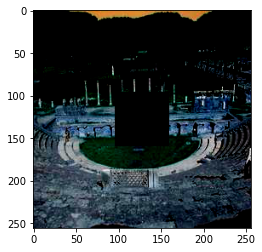

In [7]:
def imshow(img):
    img = img.transpose(0,2).transpose(0,1).numpy()
    plt.imshow(img)
    # Checking that I acutally have the pics associated
i = np.random.randint(0,len(imgs))
sample = imgs[i]
x, y = sample
print(x.shape)
imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


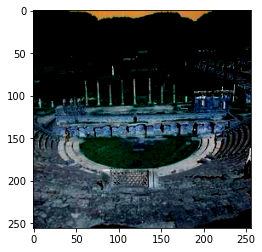

In [8]:
imshow(y)

In [10]:
train_loader = D.DataLoader(imgs, batch_size = 32, shuffle = True, num_workers = 4)

In [12]:
class Net(nn.Module):
    def __init__(self, num_latent):
        super().__init__()
        
        #So here we will first define layers for encoder network (VGG_16)
        self.encoder = nn.Sequential(nn.Conv2d(1, 64, 3),    # 98*98*64
                                     nn.Conv2d(64, 64, 3),   # 96*96*64   
                                     nn.MaxPool2d(2, 2),     # 48*48*64
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(True),
                                     nn.Conv2d(64, 128, 3),    # 46*46*128
                                     nn.Conv2d(128, 128, 3),   # 44*44*128
                                     nn.MaxPool2d(2, 2),       # 22*22*128
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(True),
                                     nn.Conv2d(128, 256, 3),   # 20*20*256
                                     nn.Conv2d(256, 256, 3),   # 18*18*256
                                     nn.Conv2d(256, 256, 3),   # 16*16*256
                                     nn.MaxPool2d(2, 2),       # 8*8*256
                                     nn.BatchNorm2d(256),
                                     nn.LeakyReLU(True))

                                    


        #These two layers are for getting logvar and mean
        self.fc1 = nn.Linear(16384, 8000)
        self.mean = nn.Linear(8000, num_latent)
        self.var = nn.Linear(8000, num_latent)
        
        #######The decoder part
        #This is the first layer for the decoder part
        self.expand = nn.Linear(num_latent, 8000)
        self.fc4 = nn.Linear(8000, 16384) # this represents a 8*8*256 cube
        self.decoder = nn.Sequential(nn.ConvTranspose2d(256, 128, 5, stride=2), # 19*19*128
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(128, 64, 5, stride=2), # 41*41*64
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(64, 32, 5, stride=2),  # 85*85*32
                                     nn.BatchNorm2d(32),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(32, 16, 6, stride=1),    # 89*89*16
                                     nn.BatchNorm2d(16),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(16, 8, 6, stride=1), # 94*94*8
                                     nn.BatchNorm2d(8),
                                     nn.LeakyReLU(True),
                                     nn.ConvTranspose2d(8, 1, 6, stride=1)) # 100*100*1
                                     

        
    def enc_func(self, x):
        #here we will be returning the logvar(log variance) and mean of our network
        x = self.encoder(x)
        x = x.view([-1, 16384])
        x = self.fc1(x)

        
        mean = self.mean(x)
        logvar = self.var(x)
        return mean, logvar
    
    def dec_func(self, z):
        #here z is the latent variable state
        z = self.expand(z)
        z = self.fc4(z)
        z = z.view([-1, 256, 8, 8])
        
        out = self.decoder(z)
        out = torch.sigmoid(out)
        return out
    
    def get_hidden(self, mean, logvar):
        std = torch.exp(0.5*logvar)   # get std
        noise = torch.randn_like(mean)   # get the noise of standard distribution
        return noise.mul(std).add_(mean)

    
    def forward(self, x):
        mean, logvar = self.enc_func(x)
        z = self.get_hidden(mean, logvar)
        out = self.dec_func(z)
        # print(out.shape)
        return out, mean, logvar

def VAE_loss(x_recon, y, mean, logvar):
    ### MSE
    base_loss = nn.MSELoss()
    loss = base_loss(x_recon, y)

    # Scale the following losses with this factor
    scaling_factor = x_recon.shape[0]*x_recon.shape[1]*x_recon.shape[2]*x_recon.shape[3]
    
    #### define the KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.005 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    kl_loss /= scaling_factor    # trying without this values
    
    return loss + kl_loss



In [ ]:
def train(trainloader, start_epochs, epochs, model, device, optimizer, avg_losses):
    if len(avg_losses) > 1:
        avg_losses = avg_losses
    else:
        avg_losses = []
    ### Training
    for epoch in range(start_epochs+1, epochs+1):
        start = time.time()
        model.train()
        model.to(device)
        train_loss = 0
        for i,(images, target) in enumerate(trainloader):
            images = images.to(device)
            target = target.to(device)
           
            optimizer.zero_grad()
            out, mean, logvar = model(images)
            out = out.to(device)
            
            # VAE loss
            loss = VAE_loss(out, target, mean, logvar)

            # Backpropagation and optimization
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        ### Statistics   
        avg_losses.append(train_loss/len(trainloader))
        end = time.time()  
        elasped_time = (end - start)/60          
        print('=======> Epoch: {} Average loss: {:.6f}'.format(epoch, train_loss / len(data_loader)))
        print("=======> This epoch took {:.3f} mins to be completed".format(elasped_time))
        
        
    # Plotting the loss function
    plt.plot(avg_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    ### Saving the model
    torch.save({
            'epochs': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'average losses' : avg_losses
            }, 'checkpoint-{}-1500.pth.tar'.format(epochs))



######Setting all the hyperparameters
epochs = 350
num_latent = 1500

model = Net(num_latent)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Just for the first run
start_epochs = 0
avg_losses = []

## Loading the model
# checkpoint = torch.load('checkpoint-5-1500-changing.pth.tar')
# model.load_state_dict(checkpoint['model_state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epochs = checkpoint['epochs']
# avg_losses = checkpoint['average losses']

### Resume the training
train(train_loader,start_epochs, epochs, model, device, optimizer, avg_losses)